# 6. Transformer models for text processing

In the previous documents, we have looked at several different neural network models for classifying movie reviews according to their sentiment (positive/negative). Now that we are acquainted with all the necessary building blocks, we are ready to assemble a complete Transformer model. 

In [1]:
import keras
from keras import layers
from keras import ops
import numpy as np
import tensorflow as tf

## Text classification (sentiment analysis)

For simplicity, we keep using the same (by now very familiar) IMDB dataset:

In [2]:
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory( 
    '../../aclImdb/train/', 
    validation_split=0.2, 
    subset="training", 
    seed=123,
    batch_size=batch_size)

val_ds = keras.utils.text_dataset_from_directory( 
    '../../aclImdb/train/', 
    validation_split=0.2, 
    subset="validation", 
    seed=123, # same seed as above!
    batch_size=batch_size)

test_ds = keras.utils.text_dataset_from_directory( 
    '../../aclImdb/test/', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


As before, we preprocess the original string-valued samples to integer-valued token sequences of fixed length:

In [3]:
vocab_size = 10000 # maximum number of tokens in vocabulary 
sequence_length = 250 # maximum length of sequences

vectorization_layer = layers.TextVectorization( 
    max_tokens=vocab_size, 
    output_mode='int',
    output_sequence_length=sequence_length,
)

train_texts = train_ds.map(lambda x, y: x) 
vectorization_layer.adapt(train_texts)

train_ds_int = train_ds.map(lambda x, y: (vectorization_layer(x), y)) 
val_ds_int = val_ds.map(lambda x, y: (vectorization_layer(x), y))
test_ds_int = test_ds.map(lambda x, y: (vectorization_layer(x), y))

Now we define a custom layer for converting the integer lists to word vectors. This layer consists of two separate Embedding layers: one encoding the tokens, and one encoding their positions in the sample. The final embeddings are obtained by summing these two separate contributions. Note that we also include the ability to include a mask for ignoring the padding zeroes in the input samples, as well as a `get_config` method to allow for saving the model after training. 

In [4]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

We are now ready to build the Transformer model; the structure of the original model is presented in the image below (Yuening Jia, CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons):

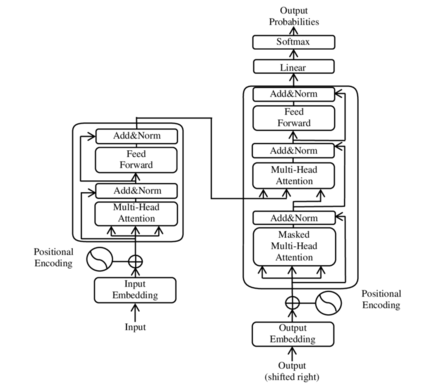

In [5]:
from IPython.display import Image,display;display(Image(filename="Images/The-Transformer-model-architecture.png"))

For the purpose of our classification model, we shall employ the **encoder** part of the architecture, which constitutes the left-hand part in the image above. First, the embedded input samples enter the multi-head attention layer, whose output is then summed with the original input coming through a residual connection. Following a normalization, the tensor enters a fully connected segment containing two Dense layers. The output from this dense projection is then added to the input tensor via a residual connection, and normalized once more to produce the final output of the Transformer encoder.

In [6]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


We are now ready to build the actual classifier model. The output from the encoder is flattened by a global pooling layer, and then fed straight into the output layer of a single neuron with sigmoid activation.

In [7]:
embed_dim = 32 # dimension of word embeddings (token + pos)
dense_dim = 64 # 
num_heads = 2

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=keras.optimizers.RMSprop(), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 32)  │    328,000 │ input_layer[0][0] │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, None, 32)  │     12,736 │ positional_embed… │
│ (TransformerEncode… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ transformer_enco… │
│ (GlobalAveragePool… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 340,769 (1.30 MB)

 Trainable params: 340,769 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

Train the model ...

In [8]:
history = model.fit(
    train_ds_int, 
    batch_size=batch_size, 
    epochs=3, 
    validation_data=(val_ds_int)
)


Epoch 1/3


C:\Users\kopuj\Anaconda3\envs\keras-cpu\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\kopuj\Anaconda3\envs\keras-cpu\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\kopuj\Anaconda3\envs\keras-cpu\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  war

625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.6951 - loss: 0.5571 - val_accuracy: 0.7462 - val_loss: 0.5242
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.8637 - loss: 0.3234 - val_accuracy: 0.8492 - val_loss: 0.3606
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.8897 - loss: 0.2749 - val_accuracy: 0.8740 - val_loss: 0.2977


... and test it.

In [10]:
model.evaluate(test_ds_int)

782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8656 - loss: 0.3205


[0.31755366921424866, 0.8659600019454956]

## Text generation

In addition to simple tasks like classification, Transformer architecture models can also be used for more ambitious natural language processing tasks, such as machine translation and text generation. Here we shall take a look at how a neural network model can be trained to produce movie reviews from an initial prompt. 

We begin by creating a new Dataset object from the data in the training directory only. This time, we do not need the sentiment labels, and remove the line break tokens in order to avoid generating those later.

In [11]:
dataset = keras.utils.text_dataset_from_directory(
    directory="../../aclImdb/train/", 
    label_mode=None, 
    batch_size=256)

dataset = dataset.map(lambda x: tf.strings.regex_replace(x, "<br />", ""))

Found 25000 files.


Next, we convert the strings to integer lists, as before. To speed up training, we restrict the sequence lengths to be somewhat shorter than before.

In [12]:
sequence_length = 100
vocab_size = 10000
text_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
text_vectorization.adapt(dataset)

Next, we generate specialized targets for the purpose of training the model: the targets are simply the same integer sequences as the samples, but shifted one token to the right (this means that the sequence length gets reduced by one token from the original ones). 

In [13]:
def prepare_lm_dataset(text_batch):
    vectorized_sequences = text_vectorization(text_batch)
    x = vectorized_sequences[:, :-1]
    y = vectorized_sequences[:, 1:]
    return x, y

lm_dataset = dataset.map(prepare_lm_dataset)

For the actual text generation, we need to employ the **decoder** part of the Transformer (the right-hand side of the architecture image above). The building blocks of the decoder are very similar to those of the encoder, but with a couple of differences. First, there are two separate attention layers; the first layer takes the embedded inputs in as query, key and value. The second attention layer takes the output of the first one in as the query. In the case of a machine translation task the key and value would come from in from the encoder outputs generated by the source sequence to be translated; here, however, there is no such separate source sequence, but the keys and values are provided by the original inputs to the decoder.

Another important detail is the **causal mask**, which prevents the generated from attending to future words, when predicting a given word in a sequence. The implementation of this, as well as all the other essentials of the code are from F. Chollet: **Deep Learning with Python** (Chapter 12), with migration guidelines to Keras 3 in [this example](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/).

In [14]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
            padding_mask = ops.minimum(padding_mask, causal_mask)
        else:
            padding_mask = None

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

We are now ready to build the model with the Transformer decoder. Its output is directly connected to the output layer with the size of the vocabulary and softmax activation, to provide a probability distribution for token predictions. Note that we choose `sparse_categorical_crossentropy` as our loss function, because the target labels consist of integers (instead of being one-hot encoded).

In [15]:
embed_dim = 32
latent_dim = 64
num_heads = 2

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, x)
outputs = layers.Dense(vocab_size, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=keras.optimizers.RMSprop())

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 32)  │    323,200 │ input_layer_2[0]… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decoder │ (None, None, 32)  │     21,216 │ positional_embed… │
│ (TransformerDecode… │                   │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, None,      │    330,000 │ transformer_deco… │
│                     │ 10000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 674,416 (2.57 MB)

 Trainable params: 674,416 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

Now we can train the model.

In [16]:
model.fit(lm_dataset, epochs=1)

98/98 ━━━━━━━━━━━━━━━━━━━━ 72s 697ms/step - loss: 8.3777


Once the model has been trained, we can experiment with generating text from an initial seed prompt. Instead of always predicting the token with the highest probability in the predicted distribution, we scale the distribution with a parameter referred to as **temperature**: high values of temperature tend to flatten the probability distribution, which leads to somewhat more surprising choices for next tokens.

In [17]:
tokens_index = dict(enumerate(text_vectorization.get_vocabulary()))

def sample_next(predictions, temperature=1.0):
    predictions = np.asarray(predictions).astype("float64")
    predictions = np.log(predictions) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, predictions, 1)
    return np.argmax(probas)

Finally, we can define an initial prompt, and check out the quality of generated text. Unfortunately, due to the short training time, the results are fairly disappointing. 

In [18]:
temperature = 0.5

sentence = "in my view"
generate_length = 50
for i in range(generate_length):
    tokenized_sentence = text_vectorization([sentence])
    predictions = model(tokenized_sentence)
    next_token = sample_next(predictions[0, i, :])
    sampled_token = tokens_index[next_token]
    sentence += " " + sampled_token
print(sentence)

in my view [UNK] dan loser best doesnt a shaped videos [UNK] reckless opposite believe favourite definitely was are wont twodimensional were bad kind writer hours never alternately other ensues minions subsequently use me seen an intent a dvd pulling even mystery tripe any dance more hartleys thrown justified increasingly this canada former
